In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Lenses.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate

import matplotlib.pyplot as plt
import corner

from slsim.Plots.lens_plots import LensingPlots
import tqdm

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


## Lensed quasar + host galaxy population

This notebook shows how to simulate lensed quasar population with/without host galaxies.

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=5, unit="deg2")
quasar_sky_area = Quantity(value=5, unit="deg2")
full_sky_area = Quantity(value=10, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 30, "z_min": 0.01, "z_max": 5}
kwargs_source_cut = {"z_min": 0.001, "z_max": 5.0}

In [3]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=None,
)

In [4]:
# Initiate deflector population class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/Users/paras/Projects/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:56: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/paras/Projects/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:59: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [5]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)

# quasar sample without host galaxy
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=28, host_galaxy=False)

# quasar sample with host galaxy
quasar_source_plus_galaxy = quasar_class.quasar_sample(
    m_min=15, m_max=28, host_galaxy=True
)

Matching quasars with host galaxies:  10%|█         | 2260/22344 [00:00<00:03, 5747.74it/s]/Users/paras/Projects/repos/self/slsim/slsim/Sources/SourceCatalogues/QuasarCatalog/quasar_host_match.py:123: RuntimeWarning: divide by zero encountered in log10
  M_bol = M_bol_sun - 2.5 * np.log10(L_bol)  # L_sun
Matching quasars with host galaxies: 100%|██████████| 22344/22344 [00:03<00:00, 5976.10it/s]


In [6]:
quasar_source

z,M_i,ps_mag_i
float64,float64,float64
2.6366285213189027,-21.961459640863897,23.879342862066746
2.1886865526503394,-19.255023932774304,26.12627886593079
1.0254075333399897,-18.495105567734196,25.11208923475269
1.025329153787858,-16.234799258141887,27.372268657764018
0.6208420686921784,-19.34881074468338,23.073423628376283
3.29229298970537,-18.529904123251832,27.809804697061615
2.195932092875692,-17.64760933486987,27.743172457137455
2.546343481349763,-18.010670583354134,27.77919600515797
0.3716529253221426,-14.013462964694215,27.289828844452245


In [7]:
quasar_source_plus_galaxy

z,M_i,ps_mag_i,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_y,vel_disp,black_hole_mass_exponent,eddington_ratio
,,,,,,kpc,,rad,,,,,,,,
float64,float64,float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.6366285213189027,-21.961459640863897,23.879342862066746,-21.15295659712724,0.244370099782747 .. 0.0901123656682181,0.4604230806747065,2.4500862693006473,39635931607.51989,1.4894137695423316e-06,25.9372419236891,25.781730063435297,25.562814884288343,25.514049633412924,25.34782635917054,115.08710824041667,7.4401471616428925,0.43655305514394394
2.1886865526503394,-19.255023932774304,26.12627886593079,-19.620668676623097,0.2919551440868723 .. 0.04812745073398792,0.0847749644585734,2.1129480940208243,6583398788.023938,1.2383320544651072e-06,27.35382123716609,27.07109548772016,26.983345094983452,26.80643292509647,26.527780226111364,63.98441182896831,6.323455230377649,0.47962537778552633
1.0254075333399897,-18.495105567734196,25.11208923475269,-18.070723653372085,0.19789885446360375 .. 0.02855792176976904,0.6562029026077941,2.430550954388558,4503661039.32409,1.4628197901875172e-06,26.607702220187676,26.329115354725182,25.897719903569396,25.37121675817287,25.124772836053616,53.477857871115106,5.9822524445543985,0.521067511249811
1.025329153787858,-16.234799258141887,27.372268657764018,-15.474434656347018,0.12529031894401574 .. 0.19902277979654065,0.3061730506170762,0.9453524132997599,135919616.14139143,5.690196075796372e-07,29.207732052876587,28.793241602743272,28.391744421749102,27.935039078802674,27.807813162696647,33.366453295816214,5.084948312354676,0.511666501988164
0.6208420686921784,-19.34881074468338,23.073423628376283,-18.594637276749154,0.28473485301302487 .. 0.04358827616351592,0.2643728974715835,6.8872613793612505,5737702715.381818,4.917180073295815e-06,24.943175730852726,24.17372613304477,23.572495274301975,23.395364619869884,23.209012124413018,60.464886168413045,6.215834502291086,0.6687388066845946
3.29229298970537,-18.529904123251832,27.809804697061615,-19.349642601288576,0.333979133498923 .. 0.12121183075715772,0.4985221247033056,1.7277865680292321,8372378148.943435,1.1198503007552347e-06,29.115601396459194,28.583151141972525,28.34697542144892,28.120937131474147,27.9858076392641,70.38824578018657,6.504900934026787,0.16124471112412733
2.195932092875692,-17.64760933486987,27.743172457137455,-18.070488592944155,0.6090629639976273 .. 0.027181914632927167,0.10952813915632804,2.0580236760576742,2670666738.977262,1.2067507576694544e-06,27.86741726213728,27.765828841814802,27.752982213564863,27.727161613250374,27.640572500450965,43.011518855853346,5.567951644696394,0.6185120779357872
2.546343481349763,-18.010670583354134,27.77919600515797,-18.459931088777807,0.23196709016553813 .. 0.04625015991454028,0.9565259188742766,3.410446664344078,3449591051.417615,2.056621638450786e-06,28.427395179921305,28.284960639747496,28.110477373307567,28.128512341099906,27.97711458263361,45.84876563383608,5.689465410382722,0.6489020018293551


In [8]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}


kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r", "g"},
    # "kwargs_variability_model": {"agn_lightcurve", "i", "r", "g"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 500),
    "r_resolution": 500,
    "corona_height": 10,
}

In [9]:
# Initiate source population classes.

# Point source quasar population without host galaxy
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    # catalog_type="skypy",
    point_source_type="quasar",
    point_source_kwargs=kwargs_quasar,
)

# Point source quasar population with host galaxy
source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    point_source_type="quasar",
    extended_source_type="single_sersic",
    point_source_kwargs=kwargs_quasar,
)

In [10]:
# Initiate LensPop class to generate lensed quasar pop. We simulate lens pop in 500
# deg^2. If you want to simulate in larger sky, change sky area to your requirement.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

quasar_plus_galaxies_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Properties of the lensed quasar population

Text(0.5, 1.05, 'Quasar Source Population')

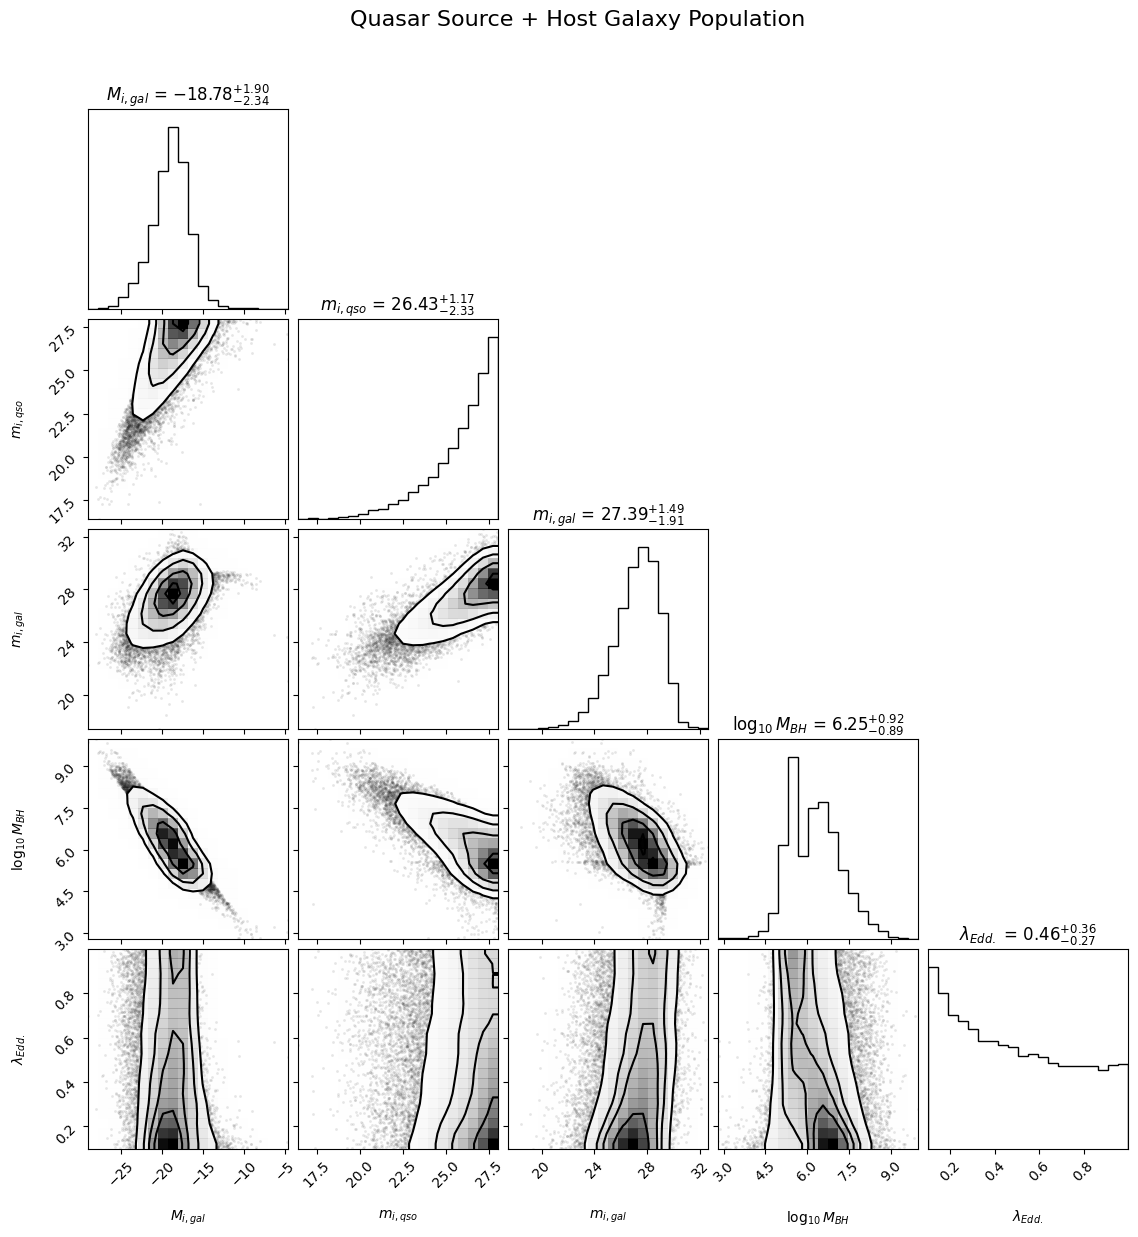

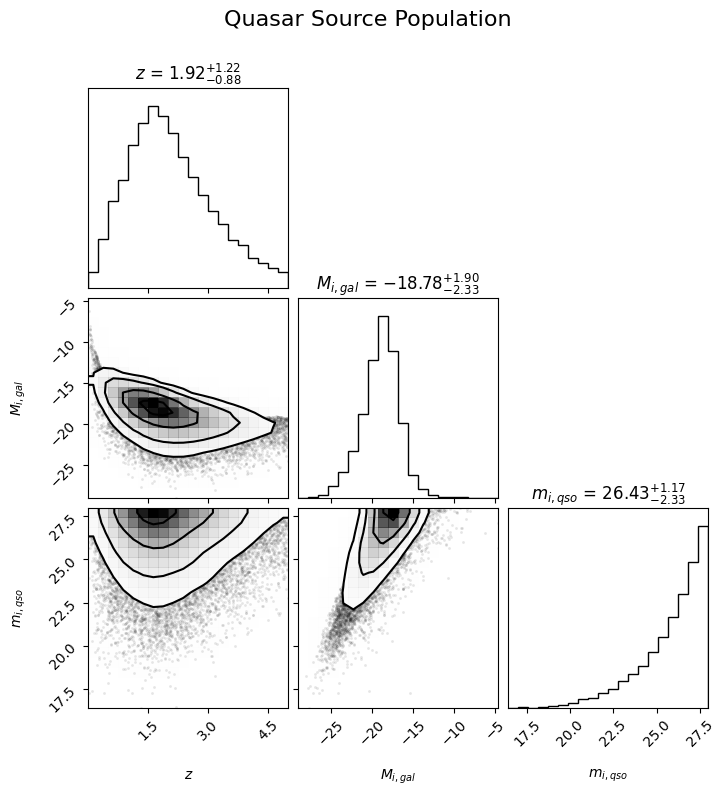

In [11]:
# we make a corner plot for both the lens populations

keys = [
    # "z",
    "M_i",
    "ps_mag_i",
    "mag_i",
    "black_hole_mass_exponent",
    "eddington_ratio",
]

key_labels = {
    "z": r"$z$",
    "M_i": r"$M_{i, gal}$",
    "ps_mag_i": r"$m_{i, qso}$",
    "mag_i": r"$m_{i, gal}$",
    "black_hole_mass_exponent": r"$\log_{10} M_{BH}$",
    "eddington_ratio": r"$\lambda_{Edd.}$",
}

mask_finite = np.isfinite(quasar_source_plus_galaxy["black_hole_mass_exponent"])
data_qso_plus_gal_dict = {
    key: quasar_source_plus_galaxy[key][mask_finite] for key in keys
}
data_qso_plus_gal = np.array([data_qso_plus_gal_dict[key] for key in keys]).T

fig = corner.corner(
    data_qso_plus_gal,
    labels=[key_labels[key] for key in keys],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth=True,
)
fig.suptitle(
    "Quasar Source + Host Galaxy Population",
    fontsize=16,
    y=1.05,
)

data_qso_only_dict = {key: quasar_source[key] for key in ["z", "M_i", "ps_mag_i"]}
data_qso_only = np.array(
    [data_qso_only_dict[key] for key in data_qso_only_dict.keys()]
).T

fig = corner.corner(
    data_qso_only,
    labels=[key_labels[key] for key in data_qso_only_dict.keys()],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth=True,
)
fig.suptitle(
    "Quasar Source Population",
    fontsize=16,
    y=1.05,
)

## Plot lenses

In [12]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 4,
    "max_image_separation": 30,
    "mag_arc_limit": {"g": 23, "r": 23, "i": 23},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(
    quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10
)

In [15]:
# make some cuts in the image separations and limited magnitudes of the arc
kwargs_lens_cut_plot = {
    "min_image_separation": 1,
    "max_image_separation": 30,
    "mag_arc_limit": {"i": 23},
    "second_brightest_image_cut": {"i": 24},
}

quasar_plot = LensingPlots(quasar_lens_pop, num_pix=64, coadd_years=10)
quasar_plus_galaxies_plot = LensingPlots(
    quasar_plus_galaxies_lens_pop, num_pix=64, coadd_years=10
)

# select lenses for plotting
selected_lenses_quasar = []
selected_lenses_quasar_plus_galaxies = []

for _ in tqdm.trange(16, desc="Selecting lenses at random"):
    selected_lenses_quasar.append(
        quasar_lens_pop.select_lens_at_random(
            **kwargs_lens_cut_plot,
        )
    )
    selected_lenses_quasar_plus_galaxies.append(
        quasar_plus_galaxies_lens_pop.select_lens_at_random(
            **kwargs_lens_cut_plot,
        )
    )

# get rgb images of the selected lenses
rgb_images_quasar = []
rgb_images_quasar_plus_galaxies = []

for i in tqdm.trange(len(selected_lenses_quasar), desc="Generating RGB images"):
    rgb_images_quasar.append(
        quasar_plot.rgb_image(
            selected_lenses_quasar[i],
            rgb_band_list=["i", "r", "g"],
        )
    )
    rgb_images_quasar_plus_galaxies.append(
        quasar_plus_galaxies_plot.rgb_image(
            selected_lenses_quasar_plus_galaxies[i],
            rgb_band_list=["i", "r", "g"],
        )
    )

print(f"Number of selected lenses [quasar]: {len(selected_lenses_quasar)}")
print(
    f"Number of selected lenses [quasar + host galaxy]: {len(selected_lenses_quasar_plus_galaxies)}"
)

Generating RGB images: 100%|██████████| 16/16 [00:00<00:00, 40.97it/s]

Number of selected lenses [quasar]: 16
Number of selected lenses [quasar + host galaxy]: 16


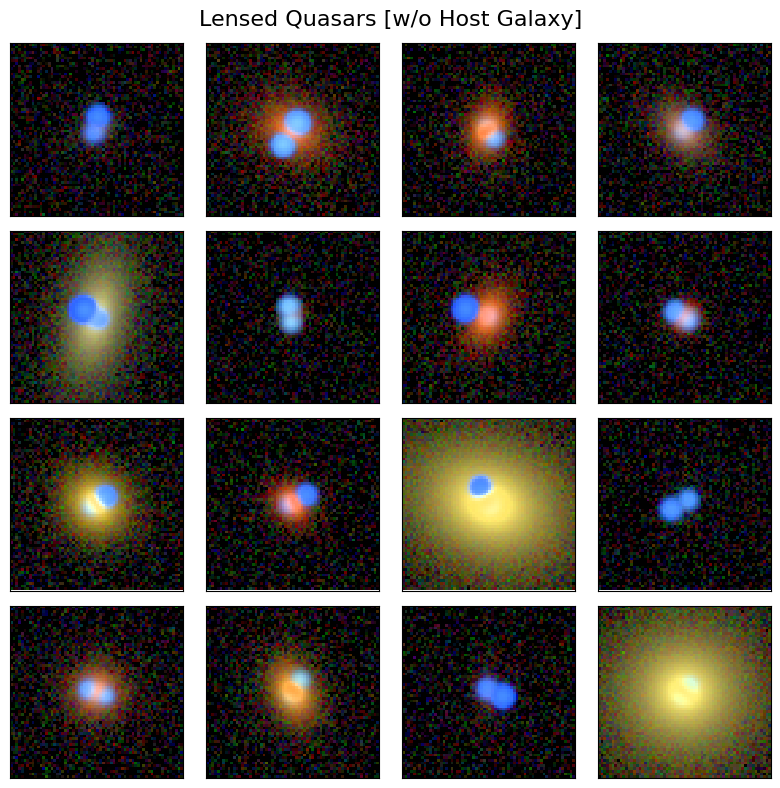

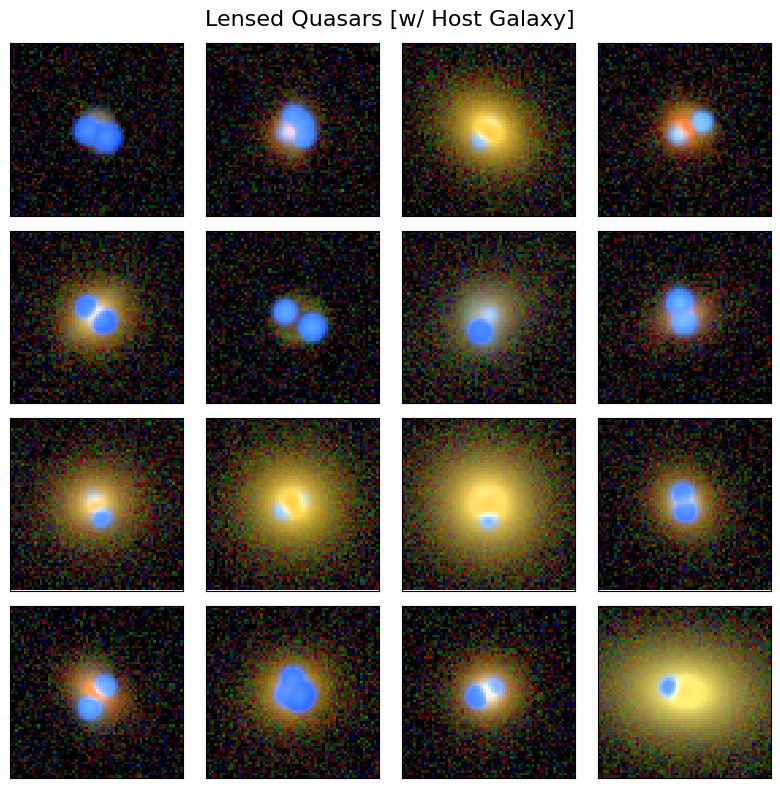

In [16]:
# make montage of the rgb images for both the lens populations

# quasar lens montage
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(8, 8),
    subplot_kw={"xticks": [], "yticks": []},
)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            rgb_images_quasar[i * 4 + j],
            origin="lower",
            interpolation="nearest",
        )
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
# fig.subplots_adjust(top=0.9)
fig.tight_layout()

# quasar + host galaxy lens montage
fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(8, 8),
    subplot_kw={"xticks": [], "yticks": []},
)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(
            rgb_images_quasar_plus_galaxies[i * 4 + j],
            origin="lower",
            interpolation="nearest",
        )
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
# fig.subplots_adjust(top=0.9)
fig.tight_layout()

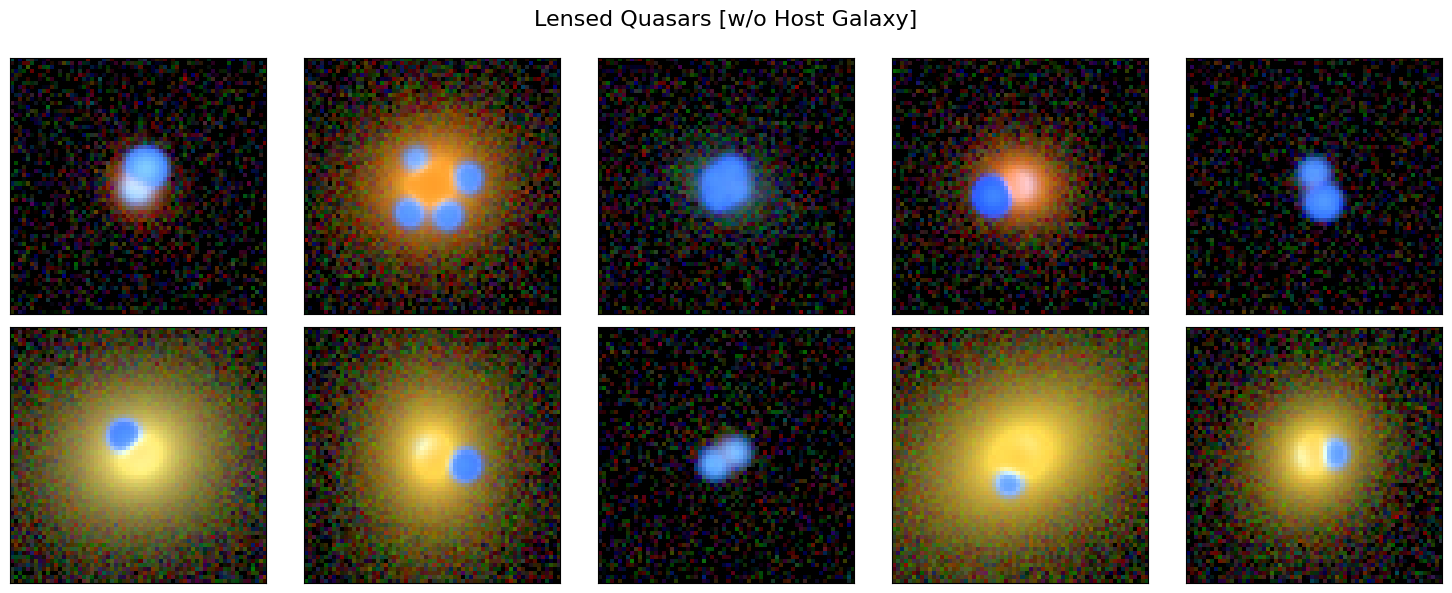

In [17]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/o Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

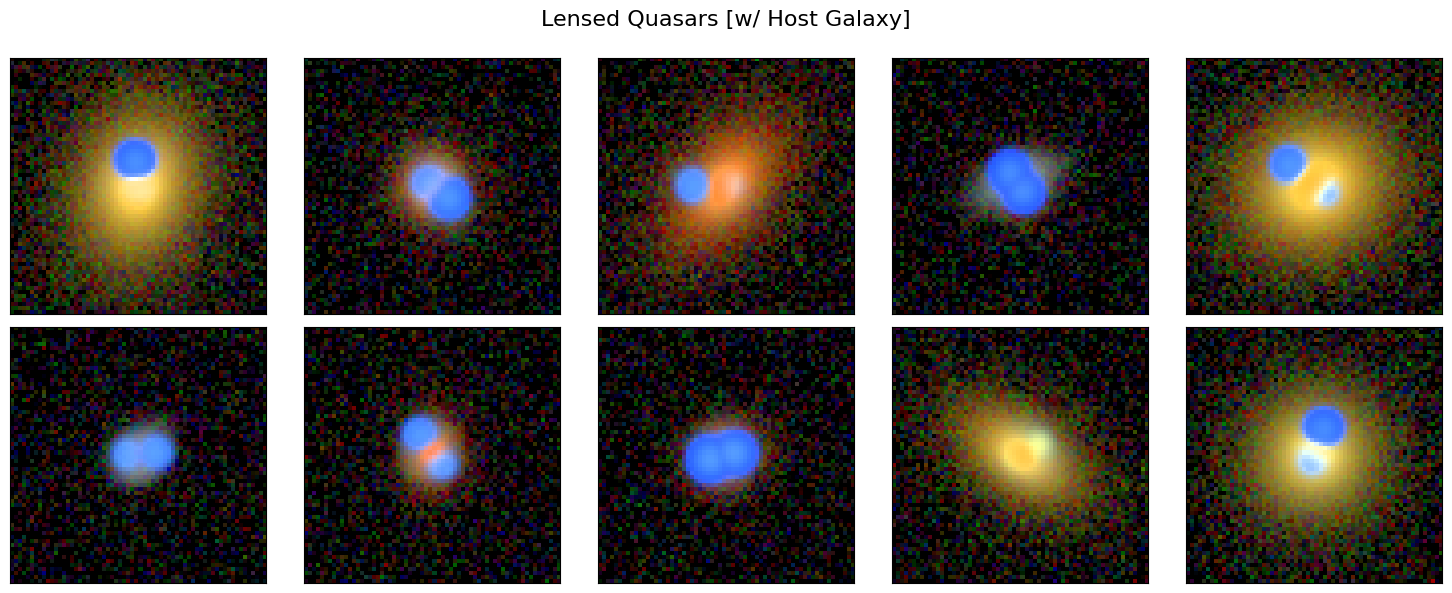

In [18]:
# generate montage indicating which bands are used for the rgb color image
fig, axes = quasar_plus_galaxies_plot.plot_montage(
    rgb_band_list=["i", "r", "g"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
fig.suptitle("Lensed Quasars [w/ Host Galaxy]", fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()